# Symptom Extraction and Linking from Vaccine Adverse Event Reports
### author: Matthew Hullstrung

### Import packages 

In [1]:
import stanza
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


stanza.download('en', package='i2b2')

C:\Users\Matt H\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-09 15:31:50 INFO: Downloading these customized packages for language: en (English)...
| Processor       | Package |
-----------------------------
| ner             | i2b2    |
| backward_charlm | mimic   |
| pretrain        | mimic   |
| forward_charlm  | mimic   |

2023-11-09 15:31:50 INFO: File exists: C:\Users\Matt H\stanza_resources\en\ner\i2b2.pt
2023-11-09 15:31:50 INFO: File exists: C:\Users\Matt H\stanza_resources\en\backward_charlm\mimic.pt
2023-11-09 15:31:51 INFO: File exists: C:\Users\Matt H\stanza_resources\en\pretrain\mimic.pt
2023-11-09 15:31:51 INFO: File exists: C:\Users\Matt H\stanza_resources\en\forward_charlm\mimic.pt
2

### Load and Filter the Data

We only want 10,000 samples from the 2022 COVID-19 Vaccine VAERS reports. We must first load the data for all vaccines then filter the dataset for COVID-19 vaccine reports. 

In [10]:
# Load the VAERS DATA, VAERS Symptoms, and VAERS Vaccine datasets
data = pd.read_csv('data/2022VAERSDATA.csv', usecols=['VAERS_ID', 'SYMPTOM_TEXT'], encoding='latin1',)
symptoms = pd.read_csv('data/2022VAERSSYMPTOMS.csv', encoding='latin1')
vaccine = pd.read_csv('data/2022VAERSVAX.csv', encoding='latin1')

# Merge the VAERS DATA and VAERS Symptoms datasets based on VAERS_ID
merged_data = data.merge(symptoms, on='VAERS_ID', how='left')

# Merge the merged data and VAERS Vaccine datasets based on VAERS_ID
merged_data = merged_data.merge(vaccine, on='VAERS_ID', how='left')

# Filter the dataset for COVID-19 vaccine reports
covid_vaccine_data = merged_data[merged_data['VAX_TYPE'] == 'COVID19']

# Use only 10,000 samples from the dataset
covid_vaccine_data = covid_vaccine_data.sample(n=10000, random_state=100)

print(f'Number of samples: {len(covid_vaccine_data)}')


Number of samples: 10000


### Data Preprocessing and Analysis

We will perform some statistical analysis of our data. This will include getting the distribution of the number of different symptoms related to COVID-19 vaccines as well as getting the distribution of the length of the different reports.

We'll begin by looking at the distribution of the counts of COVID-19 related standard symptoms.

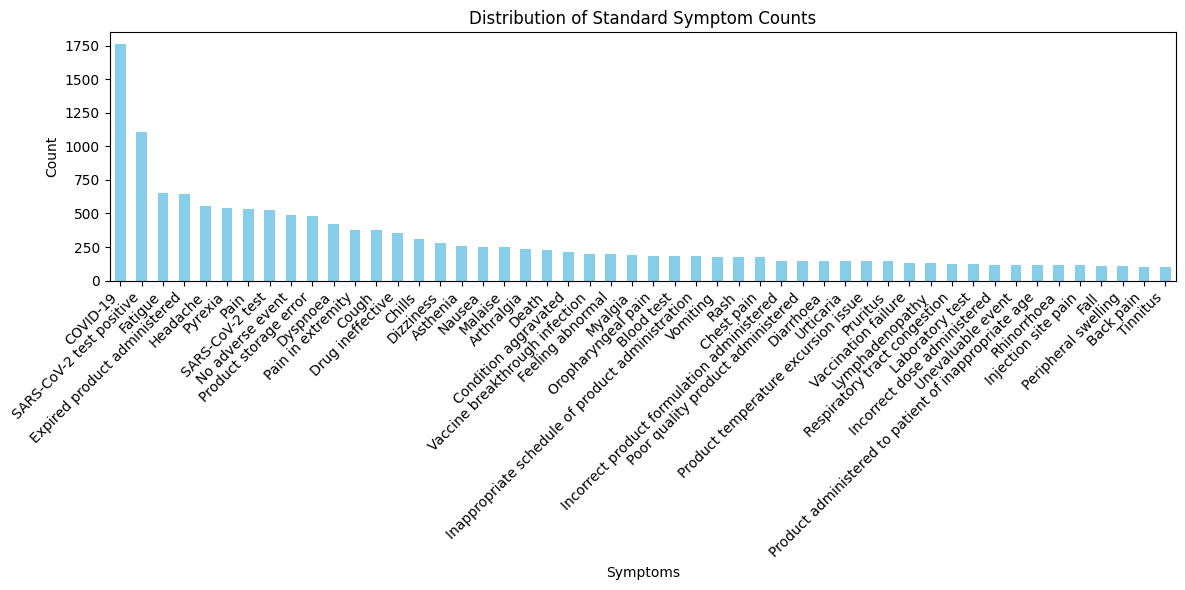

In [15]:
# Extract symptoms from columns SYMPTOM1 to SYMPTOM5
symptoms_columns = ['SYMPTOM1', 'SYMPTOM2', 'SYMPTOM3', 'SYMPTOM4', 'SYMPTOM5']
all_symptoms = covid_vaccine_data[symptoms_columns].stack()

# Get the most common symptoms (top 100 most occurring standard symptoms)
most_common_symptoms = all_symptoms.value_counts().head(100)

# Get the top 50 standard symptoms (top 100 is too many to plot nicely)
top_50_symptoms = all_symptoms.value_counts().head(50)

# Plot the distribution of symptoms
plt.figure(figsize=(12, 6))
top_50_symptoms.plot(kind='bar', color='skyblue')
plt.title('Distribution of Standard Symptom Counts')
plt.xlabel('Symptoms')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

Now let's analyze the distribution of the report lengths.

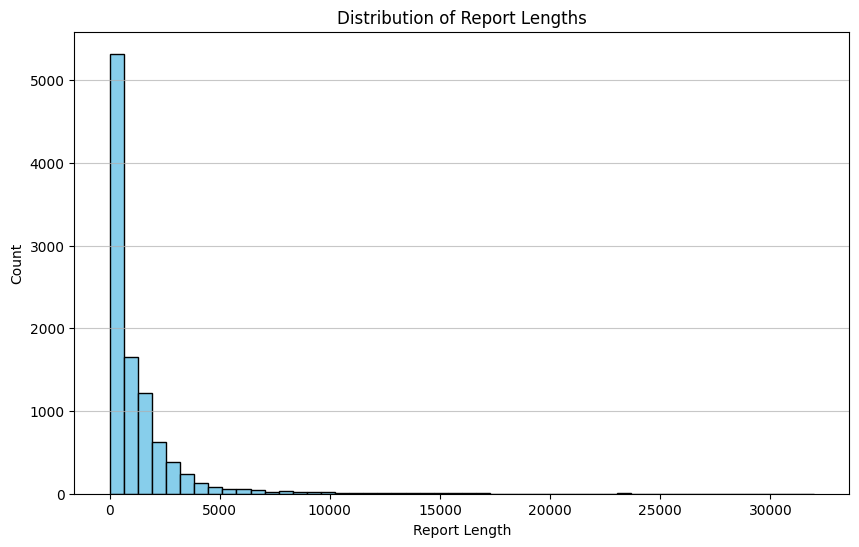

Number of Missing Reports:
8

Numerical Statistics of the Report Lengths:
count     9992.000000
mean      1203.017414
std       1924.513953
min          3.000000
25%        157.000000
50%        550.000000
75%       1519.000000
max      31989.000000
Name: SYMPTOM_TEXT, dtype: float64


In [14]:
# Calculate the length of each report
report_lengths = covid_vaccine_data['SYMPTOM_TEXT'].str.len()

# Plot the distribution of report lengths
plt.figure(figsize=(10, 6))
report_lengths.plot(kind='hist', bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Report Lengths')
plt.xlabel('Report Length')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='-', alpha=0.7)

# Show the plot
plt.show()

print("Number of Missing Reports:")
print(report_lengths.isnull().sum())

print("\nNumerical Statistics of the Report Lengths:")
print(report_lengths.describe())

Now, we will create a vocabulary of our data. This will be a sorted list of unique standard symptoms.

In [5]:
# Extract standard symptoms from the COVID-19 vaccine data
standard_symptoms_columns = ['SYMPTOM1', 'SYMPTOM2', 'SYMPTOM3', 'SYMPTOM4', 'SYMPTOM5']
all_standard_symptoms = covid_vaccine_data[standard_symptoms_columns].stack().tolist()

# Create a vocabulary (unique standard symptoms)
standard_symptoms = sorted(list(set(all_standard_symptoms)))


## Extracting Symptom-related Entities

### Initialize Stanza Package and Create Pipeline

The i2b2 package will help find entities related to PROBLEM, TEST, and TREATMENT, with PROBLEM entities being symptoms.

In [6]:
# Download biomedical models
stanza.download('en', package='mimic', processors={'ner': 'i2b2'})

# Create a Stanza pipeline
nlp = stanza.Pipeline('en', package='mimic', processors={'ner': 'i2b2'})

2023-11-09 15:31:55 INFO: Downloading these customized packages for language: en (English)...
| Processor       | Package        |
------------------------------------
| tokenize        | mimic          |
| pos             | mimic_charlm   |
| lemma           | mimic_nocharlm |
| depparse        | mimic_charlm   |
| ner             | i2b2           |
| backward_charlm | mimic          |
| pretrain        | mimic          |
| forward_charlm  | mimic          |

2023-11-09 15:31:55 INFO: File exists: C:\Users\Matt H\stanza_resources\en\tokenize\mimic.pt
2023-11-09 15:31:55 INFO: File exists: C:\Users\Matt H\stanza_resources\en\pos\mimic_charlm.pt
2023-11-09 15:31:55 INFO: File exists: C:\Users\Matt H\stanza_resources\en\lemma\mimic_nocharlm.pt
2023-11-09 15:31:55 INFO: File exists: C:\Users\Matt H\stanza_resources\en\depparse\mimic_charlm.pt
2023-11-09 15:31:55 INFO: File exists: C:\Users\Matt H\stanza_resources\en\ner\i2b2.pt
2023-11-09 15:31:55 INFO: File exists: C:\Users\Matt H\stanza

### Extract Symptom-related Entities

We will use the stanza package to help extract symptoms. We will input the descriptions of the vaccine adverse events (symptom texts) and output a list of symptom related entities. Again, PROBLEM entities are symptoms.

In [26]:


# Process text and extract entities
def extract_symptom_entities(text):
    doc = nlp(text)
    entities = []
    for sentence in doc.sentences:
        for ent in sentence.ents:
            # Check if the entity is related to symptoms (PROBLEM or DISEASES)
            if ent.type == 'PROBLEM':
                entities.append(ent.text)
    return entities

# Example usage

print(covid_vaccine_data['SYMPTOM_TEXT'].iloc[0])
symptom_entities = extract_symptom_entities(covid_vaccine_data['SYMPTOM_TEXT'].iloc[0])
print(symptom_entities)


Pt was admitted to hospital with a positive COVID test on 1/21 and transferred to another hospital on 1/25.  Prior to arrival the pt had 6 days of worsening cough, fever, extreme fatigue, and worsening shortness of breath.
['a positive COVID test', 'worsening cough', 'fever', 'extreme fatigue', 'worsening shortness of breath']
